# Extracting ViT Embeddings (Feature Bank Creation)

This step establishes the foundation for all downstream anomaly detection experiments.  
We process all *normal* training images with a pre-trained Vision Transformer (ViT) backbone and store the resulting **global and local embeddings** as a structured **feature bank**.

These embeddings serve as the reference distribution: test images will later be compared against this bank to compute anomaly scores and generate heatmaps.  
By decoupling feature extraction from the actual scoring step, we avoid repeatedly running the backbone model and gain significant speed during experimentation.

**Objectives of this step:**
- Load a pre-trained ViT backbone (DINOv2-B/14 or MAE-B/16).  
- Apply the corresponding preprocessing pipeline (resize → normalize).  
- Process each *normal* training image to extract both:
  - **Global [CLS] embedding** (image-level)
  - **Local patch embeddings** (spatial grid)
- L2-normalize all vectors for stable distance computations.  
- Save embeddings per category to disk as a structured **feature bank**.  
- Optionally: perform a quick UMAP/t-SNE projection as a sanity check.  

After this step, we obtain a reusable feature bank that enables efficient anomaly scoring and pixel-level heatmap generation in the next stages.

---

### 🧩 Output Structure

Each category produces:
- `.npz`:  
  - `cls`: Global embedding `[N, D]`  
  - `patches`: Local patch embeddings `[N, P, D]`  
  - `patch_hw`: Grid shape (e.g., 16×16)
- `.csv`: Metadata (image path, label, split)

Saved to:
- `features_dinov2_b14/` or `features_mae_b16/` (all images)
- `featurebanks/.../` (only `train/good`, patches only)


## 1. Feature Extraction Module (`src/features_vit.py`)

All feature extraction logic for Vision Transformers (ViTs) is encapsulated in a dedicated module to keep the Jupyter notebooks clean and reusable.

### Purpose
The module handles:
- Loading different ViT backbones (currently **DINOv2-B/14** and **MAE-B/16**)
- Applying the correct preprocessing (resize, normalization)
- Running inference and extracting:
  - **Global [CLS] embeddings**
  - **Local patch embeddings**
- L2-normalizing all embeddings for consistent distance metrics
- Storing results as `.npz` feature files + `.csv` metadata
- Creating **feature banks** (only `train/good` samples) for efficient anomaly scoring

---

### Input / Output
- **Input:**  
  Image paths from the MVTec dataset (`.png` format, structured into `train/` and `test/`)
- **Output:**  
  - `features_*/{category}_*.npz` →  
    - `cls`: global [CLS] embedding `[N, 768]`  
    - `patches`: local patch embeddings `[N, P, 768]`  
    - `patch_hw`: patch grid (e.g. 16×16)
  - `features_*/{category}_meta.csv` → metadata (path, label, category, split)  
  - `featurebanks/*/*_bank_*.npz` → only `train/good` patch embeddings  
  - `featurebanks/*/*_bank_meta.csv` → metadata for feature banks

---

### Usage Example

```python
from src.features_vit import get_feature_extractor
```

#### Choose backbone
```python
extractor = get_feature_extractor("dino")  # or "mae"
```

#### Extract features for all images in a category
```python
extractor.run_all("bottle", data_dir)
```

#### Build feature bank (only train/good images)
```python
extractor.run_bank("bottle", data_dir)
```

---

### 📝 Technical Notes
- Global embeddings are extracted from the **CLS token**
- Local patch embeddings are also retained (for heatmaps and pixel-level scoring)
- All vectors are **L2-normalized** → enables cosine distance & anomaly scoring
- Output dimensionality: **D = 768** (ViT-Base hidden size)
- Patch embeddings are saved with associated **grid shape (`patch_hw`)** for reconstruction
- Decoupling feature extraction from scoring greatly speeds up later steps (no re-inference needed)

---

### ⚡ Why Google Colab?
The entire extraction was executed on **Google Colab GPUs**, because:
- Local hardware was insufficient for full MVTec inference
- Colab provides **free CUDA-capable GPUs**
- Once extracted, features were saved to **Google Drive** to ensure reproducibility and prevent recomputation

---

### ✅ Benefits of Modularization
- Clean Jupyter notebooks (no extraction clutter)
- Easy switching between backbones (e.g. **DINOv2 vs. MAE**)
- Full reproducibility: results are determined entirely by the saved `.npz` and `.csv` files
- Efficient downstream experimentation: no GPU required once features are saved



## 2. 🔍 Validation
To verify correctness, we inspected the generated feature files:

- `.npz` files contain embeddings of shape `[N, 768]`
- `.csv` metadata matches the number of images
- Feature bank files contain only `train/good` samples

In [6]:
import numpy as np, pandas as pd

arr = np.load("../features_dinov2_b14/bottle_dinov2_vitb14.npz")["features"]
meta = pd.read_csv("../features_dinov2_b14/bottle_meta.csv")

print("Features:", arr.shape)   # (292, 768)
print("Metadata rows:", len(meta))  # 292

Features: (292, 768)
Metadata rows: 292


## 3. Sanity Check Dimensionality Reduction & Visualization (PCA → UMAP / t-SNE)

We now visualize the embeddings extracted with the two backbones  
- **DINOv2-B/14** (`features_dinov2_b14/`)  
- **MAE-Base** (`features_mae_b16/`)  

Since the raw embeddings have dimensionality **D = 768**, we first apply a  
**PCA (Principal Component Analysis)** to reduce the feature space while  
**retaining 95% of the variance**.  

This step makes the results **comparable to the earlier EDA with ResNet50** and  
ensures that UMAP/t-SNE operate on a compact and denoised representation.  

The workflow is:  
1. **PCA (95% variance explained)** → typically reduces 768 → ~50 dimensions  
2. **UMAP / t-SNE** → project to 2D for visualization  

Plots are then generated with two coloring schemes:  
- **By label** (`good` vs. `defect`) → checks anomaly separation  
- **By category** (bottle, capsule, …) → shows dataset grouping  

⚠️ Note: both **train and test images** are used here.  
This step is **exploratory only** and does not affect the anomaly detection pipeline.


In [7]:
cd ./notebooks

C:\Users\Fredi\MVTec\notebooks


In [19]:
# --- PCA on ALL categories (train + test) for BOTH backbones ---
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Feature directories
FEATURE_DIRS = {
    "dino": Path("../features_dinov2_b14"),
    "mae":  Path("../features_mae_b16"),
}

results = {}

for name, FEATURES_DIR in FEATURE_DIRS.items():
    key = name
    print(f"\n=== Processing {name.upper()} from {FEATURES_DIR} ===")
    
    all_feats, all_meta = [], []
    npz_files = sorted(FEATURES_DIR.glob("*.npz"))
    if not npz_files:
        print(f"[WARN] No .npz files found in {FEATURES_DIR}")
        continue

    for f in npz_files:
        # npz: features
        X = np.load(f)["features"]          # shape (N, D)
        name = f.name
        if name.endswith("_dinov2_vitb14.npz"):
            cat = name[:-len("_dinov2_vitb14.npz")]
        elif name.endswith("_mae_b16.npz"):
            cat = name[:-len("_mae_b16.npz")]
        else:
            raise ValueError(f"Unexpected file name: {name}")
        meta_path = f.with_name(f"{cat}_meta.csv")
        if not meta_path.exists():
            print(f"[WARN] Missing meta for {f.name}, skipping.")
            continue
        meta = pd.read_csv(meta_path)
        if len(meta) != len(X):
            n = min(len(meta), len(X))
            print(f"[WARN] Length mismatch for {cat}: feats={len(X)} meta={len(meta)} → trunc to {n}")
            X = X[:n]
            meta = meta.iloc[:n].copy()

        all_feats.append(X)
        all_meta.append(meta.assign(category=cat))

    X_all = np.vstack(all_feats)
    meta_all = pd.concat(all_meta, ignore_index=True)
    print("Combined:", X_all.shape, meta_all.shape)

    # PCA to 95% variance
    pca = PCA(n_components=0.95, random_state=0)
    X_pca = pca.fit_transform(X_all)
    expl = pca.explained_variance_ratio_.sum()
    print(f"PCA → shape: {X_pca.shape}, explained variance: {expl:.3f}")

    # Build dataframe
    df_proj = meta_all.copy()
    for i in range(X_pca.shape[1]):
        df_proj[f"pca_{i+1}"] = X_pca[:, i]

    # Save results in dict
    results[key] = {
        "X_pca": X_pca,
        "df_proj": df_proj,
        "explained": expl,
    }

# Access like:
#results["dino"]["df_proj"].head()
results["mae"]["df_proj"].head()





=== Processing DINO from ..\features_dinov2_b14 ===
Combined: (5354, 768) (5354, 5)
PCA → shape: (5354, 72), explained variance: 0.950

=== Processing MAE from ..\features_mae_b16 ===
Combined: (5354, 768) (5354, 5)
PCA → shape: (5354, 27), explained variance: 0.951


,path,category,raw_label,label,split,pca_1,pca_2,pca_3,pca_4,pca_5,...,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27
0,/content/drive/MyDrive/mvtec/bottle/train/good...,bottle,good,good,train,0.018758,-0.025892,-0.007739,0.009610,0.005617,...,0.000354,0.000523,0.001271,0.001166,0.000840,-0.001161,0.000239,0.000266,-0.002153,0.002628
1,/content/drive/MyDrive/mvtec/bottle/train/good...,bottle,good,good,train,0.030364,-0.035319,-0.004209,0.015038,0.006743,...,-0.001036,-0.001304,0.003134,0.000604,0.001017,-0.002307,0.001598,-0.000704,-0.002575,-0.001391
2,/content/drive/MyDrive/mvtec/bottle/train/good...,bottle,good,good,train,0.023543,-0.028882,-0.006626,0.007520,0.005697,...,0.001501,0.002329,0.000053,-0.000411,0.000465,-0.002237,-0.003300,0.001386,-0.001395,0.001611
3,/content/drive/MyDrive/mvtec/bottle/train/good...,bottle,good,good,train,0.018425,-0.022990,-0.007742,0.005120,0.004593,...,-0.001993,0.004061,-0.002146,0.000524,0.003394,-0.003620,-0.000157,-0.000251,-0.003870,-0.000831
4,/content/drive/MyDrive/mvtec/bottle/train/good...,bottle,good,good,train,0.027536,-0.030102,-0.009259,0.009666,0.006708,...,0.000478,0.000167,-0.001288,-0.000638,0.001237,-0.001524,0.002030,-0.001307,-0.001270,-0.000598


DINO → PCA shape (5354, 72)


C:\Users\Fredi\MVTec\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


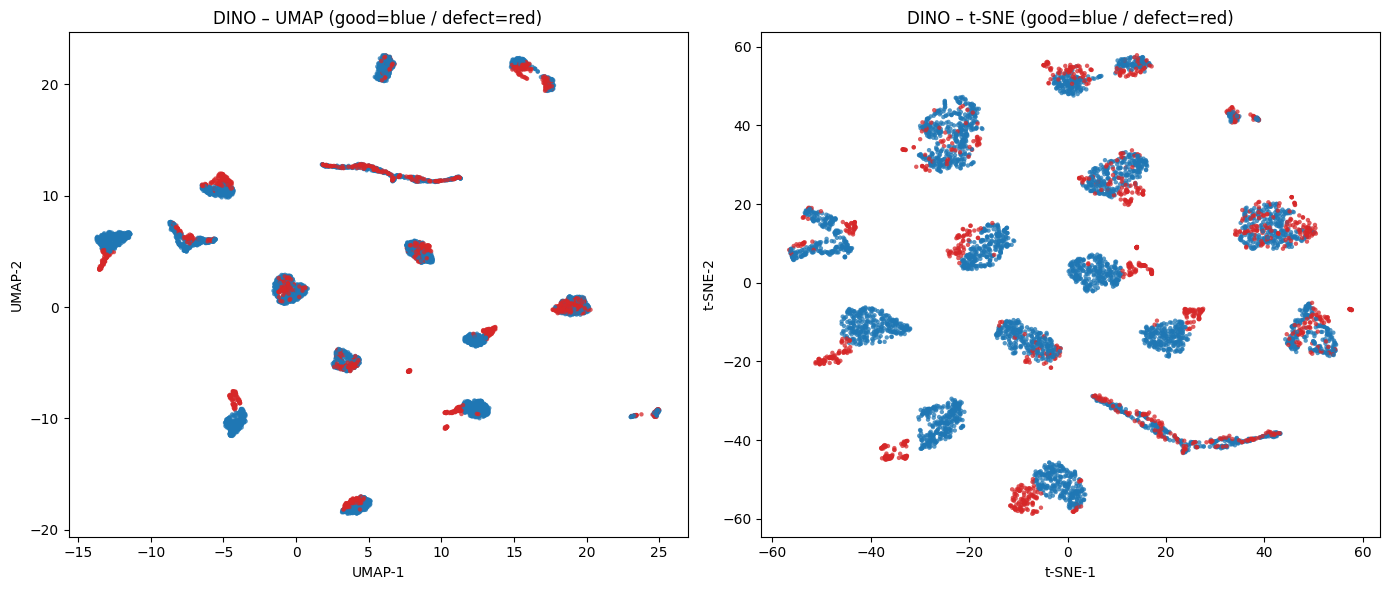

MAE → PCA shape (5354, 27)


C:\Users\Fredi\MVTec\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


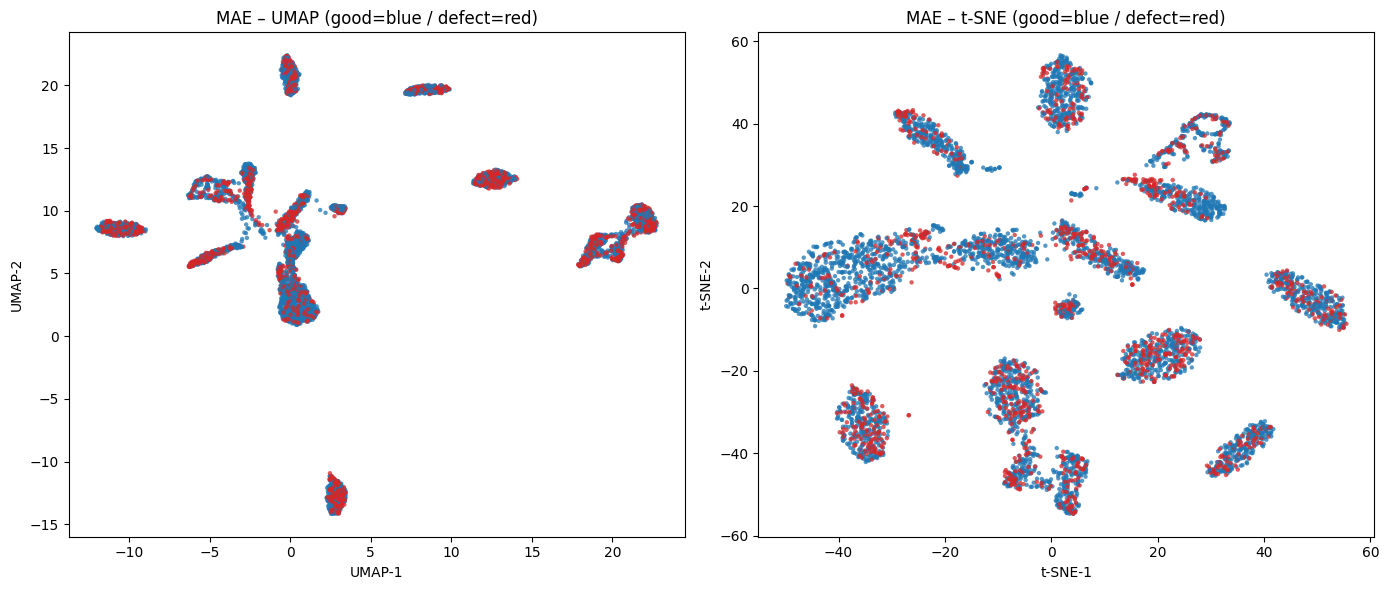

In [23]:
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
import numpy as np

def plot_umap_tsne_side_by_side(X, meta, title_prefix=""):
    # --- UMAP ---
    umap_model = umap.UMAP(
        n_components=2,
        n_neighbors=70,
        min_dist=0.3,
        metric="euclidean",
        random_state=0
    )
    X_umap = umap_model.fit_transform(X)

    # --- t-SNE ---
    N = X.shape[0]
    perp = int(np.clip(np.sqrt(N), 5, 50))
    tsne_model = TSNE(
        n_components=2,
        init="pca",
        perplexity=perp,
        learning_rate="auto",
        early_exaggeration=12.0,
        max_iter=850,
        random_state=0,
        method="barnes_hut",
        angle=0.5,
        verbose=0
    )
    X_tsne = tsne_model.fit_transform(X)

    # --- Plot side by side ---
    colors = meta["label"].map({"good": "tab:blue", "defect": "tab:red"}).fillna("tab:gray")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # UMAP
    axes[0].scatter(X_umap[:,0], X_umap[:,1], s=10, c=colors, alpha=0.75, linewidths=0)
    axes[0].set_title(f"{title_prefix} – UMAP (good=blue / defect=red)")
    axes[0].set_xlabel("UMAP-1"); axes[0].set_ylabel("UMAP-2")

    # t-SNE
    axes[1].scatter(X_tsne[:,0], X_tsne[:,1], s=10, c=colors, alpha=0.75, linewidths=0)
    axes[1].set_title(f"{title_prefix} – t-SNE (good=blue / defect=red)")
    axes[1].set_xlabel("t-SNE-1"); axes[1].set_ylabel("t-SNE-2")

    plt.tight_layout()
    plt.show()

# --- Run for both backbones ---
for backbone in ["dino", "mae"]:
    X_pca = results[backbone]["X_pca"]
    meta  = results[backbone]["df_proj"]
    print(f"{backbone.upper()} → PCA shape {X_pca.shape}")
    plot_umap_tsne_side_by_side(X_pca, meta, title_prefix=backbone.upper())



### UMAP & t-SNE on DINOv2 vs. MAE Embeddings

For both **DINOv2-B/14** and **MAE-B/16** embeddings we applied **PCA (95% variance)** followed by **UMAP** and **t-SNE** with the **same parameters as in the EDA stage**  
(`n_neighbors=70`, `min_dist=0.3`, `metric="euclidean"` for UMAP; perplexity ≈ √N, init="pca", early_exaggeration=12, max_iter=850 for t-SNE).

**Observations:**

- **DINOv2** embeddings tend to form clearer clusters in UMAP/t-SNE due to their **discriminative training objective**.  
- **MAE** embeddings appear more diffuse, as MAE is trained for **pixel reconstruction** rather than cluster-friendly representations.  
- In both cases, however, **a consistent separation between "good" and "defect" samples is not visible**.  
  → The projections are useful for visualization, but not sufficient for anomaly detection.

**Conclusion:**  
UMAP and t-SNE provide qualitative insights into the embedding space, but anomaly separation requires explicit scoring methods (e.g., KNN distances, Mahalanobis) built on the feature banks.


### Parameter Choice for UMAP / t-SNE

In this project, we used the **same UMAP/t-SNE parameters as in the EDA step**.  
This ensures **comparability** across different backbones (ResNet, DINOv2, MAE), so that observed differences can be attributed to the embeddings rather than to visualization settings.

- **Advantage:** Stable setup, fair comparison between backbones.  
- **Limitation:** The chosen parameters may not be optimal for every feature space.  

During testing, we observed that **alternative parameters (e.g. lower `n_neighbors` for UMAP, different perplexities for t-SNE)** can sometimes make **category-level clusters appear more distinct**.  
However, even with tuned parameters, the **linear separability between `good` and `defect` samples does not improve significantly**.

Since the focus of this work lies on the **representation quality and downstream anomaly scoring**, and not on hyperparameter tuning for visualization, **no additional plots are shown here**. Instead, we report this as a technical note.


## 4. ⚠️ Pitfalls & Fixes

This section documents common issues encountered during feature extraction — and how they were resolved:

- **DataLoader collation**:  
  The default PyTorch `collate_fn` breaks metadata when batching dicts.  
  → ✅ *Fix:* use a custom `collate_keep_meta` function to preserve image-level metadata.

- **Overwrite behavior**:  
  Existing `.npz` and `.csv` files are skipped by default.  
  → ✅ *Fix:* pass `overwrite=True` to force regeneration.

- **Mixed precision**:  
  Automatic Mixed Precision (AMP) was enabled on GPU for faster inference.  
  → On CPU, AMP is disabled and falls back to standard FP32.

- **Performance variance (CPU vs. GPU)**:  
  Thanks to GPU acceleration, extracting features for **all 15 MVTec categories**  
  took only a few minutes.  
  → On CPU, this would require several hours due to the high model complexity (ViT-B).

- **Preprocessing considerations**:  
  Images are resized to a fixed input size (e.g. 224×224 or 256×256 depending on the model),  
  but no center cropping is applied.  
  This ensures that **image borders are preserved**, which is especially important  
  for anomaly detection tasks where defects may occur at the edges.

  → ✅ This design choice improves robustness while remaining compatible with pretrained ViT backbones.

